<a href="https://colab.research.google.com/github/Louisfhgr/TS_Projekt/blob/main/French__bakery_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
%pip install pmdarima

In [24]:
%pip install pytrends

In [25]:
# System und allgemeine Bibliotheken
import os
import sys
import random
import requests
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Datenvisualisierung
import matplotlib.pyplot as plt
import seaborn as sns



# Skalierung und Modellierung
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split


# Zeitreihenanalyse
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller, acf, q_stat
from sklearn.metrics import mean_absolute_error

In [26]:
# Ordnerstruktur ausgeben
print("Aktueller Ordneraufbau:")
for root, dirs, files in os.walk('.'):
    level = root.replace('.', '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    sub_indent = ' ' * 4 * (level + 1)
    for f in files:
        print(f"{sub_indent}{f}")

Aktueller Ordneraufbau:
./
    Bakery sales.csv
    .config/
        hidden_gcloud_config_universe_descriptor_data_cache_configs.db
        config_sentinel
        active_config
        .last_update_check.json
        .last_opt_in_prompt.yaml
        .last_survey_prompt.yaml
        gce
        default_configs.db
        logs/
            2024.12.19/
                14.20.18.151587.log
                14.20.05.781718.log
                14.20.30.129972.log
                14.20.16.940511.log
                14.19.43.316528.log
                14.20.29.520330.log
        configurations/
            config_default
    sample_data/
        anscombe.json
        README.md
        california_housing_test.csv
        california_housing_train.csv
        mnist_train_small.csv
        mnist_test.csv


In [27]:
# https://www.kaggle.com/datasets/matthieugimbert/french-bakery-daily-sales
df_bakery_raw = pd.read_csv('Bakery sales.csv')

In [28]:
df_Process = df_bakery_raw.copy()

In [29]:
df_Process

,Unnamed: 0,date,time,ticket_number,article,Quantity,unit_price
0,0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,"0,90 €"
1,1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,"1,20 €"
2,4,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,"1,20 €"
3,5,2021-01-02,09:14,150041.0,PAIN,1.0,"1,15 €"
4,8,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,"1,20 €"
...,...,...,...,...,...,...,...
234000,511387,2022-09-30,18:52,288911.0,COUPE,1.0,"0,15 €"
234001,511388,2022-09-30,18:52,288911.0,BOULE 200G,1.0,"1,20 €"
234002,511389,2022-09-30,18:52,288911.0,COUPE,2.0,"0,15 €"
234003,511392,2022-09-30,18:55,288912.0,TRADITIONAL BAGUETTE,1.0,"1,30 €"


In [30]:
# Sicherstellen, dass alle relevanten Spalten Strings sind
df_Process['unit_price'] = df_Process['unit_price'].astype(str)
df_Process['Quantity'] = df_Process['Quantity'].astype(str)

In [31]:
# Umwandlung von Strings in numerische Formate
df_Process['unit_price'] = df_Process['unit_price'].str.replace(',', '.').str.replace(' €', '').astype(float)
df_Process['Quantity'] = df_Process['Quantity'].astype(float)
df_Process['date'] = pd.to_datetime(df_Process['date'])

In [32]:
# Umsatzspalte berechnen
df_Process['revenue'] = df_Process['Quantity'] * df_Process['unit_price']

# Explorative Datenanalyse

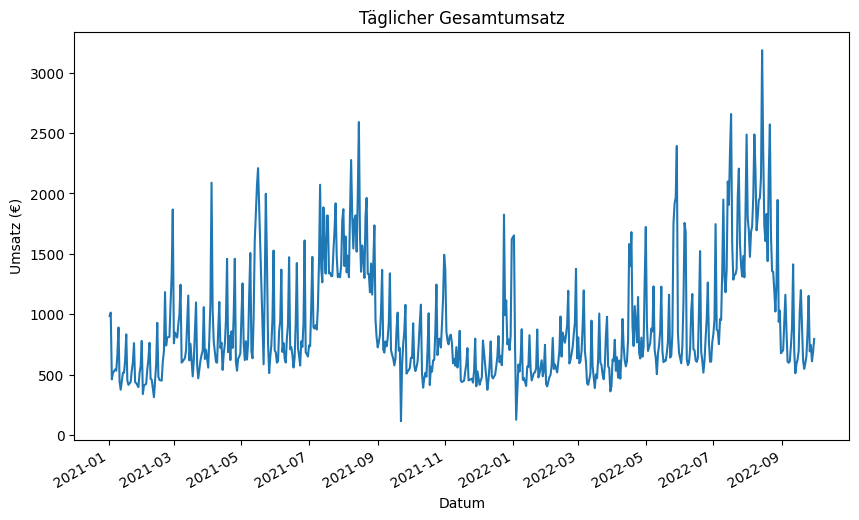

In [33]:
# Gesamtumsatz pro Tag
daily_revenue = df_Process.groupby('date')['revenue'].sum()
daily_revenue.plot(title='Täglicher Gesamtumsatz', figsize=(10, 6))
plt.xlabel('Datum')
plt.ylabel('Umsatz (€)')
plt.show()

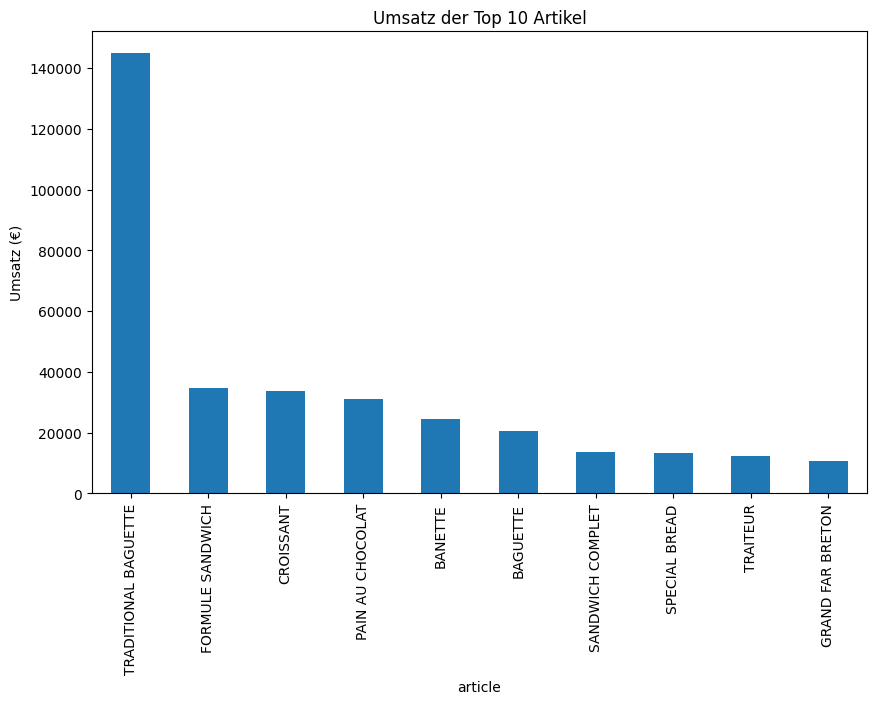

In [34]:
# Umsatz pro Artikel
article_revenue = df_Process.groupby('article')['revenue'].sum().sort_values(ascending=False)
article_revenue.head(10).plot(kind='bar', title='Umsatz der Top 10 Artikel', figsize=(10, 6))
plt.ylabel('Umsatz (€)')
plt.show()

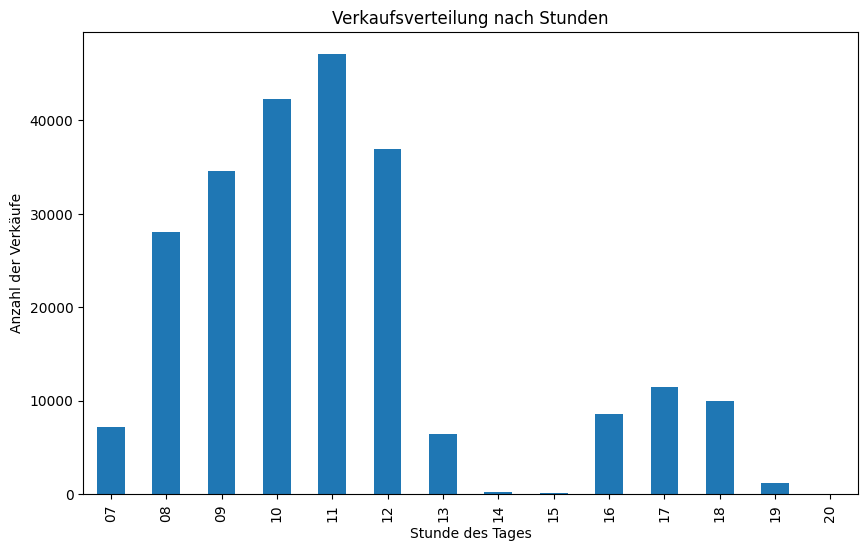

In [35]:
# Verkaufsverteilung über den Tag
hourly_distribution = df_Process['time'].str[:2].value_counts().sort_index()
hourly_distribution.plot(kind='bar', title='Verkaufsverteilung nach Stunden', figsize=(10, 6))
plt.xlabel('Stunde des Tages')
plt.ylabel('Anzahl der Verkäufe')
plt.show()

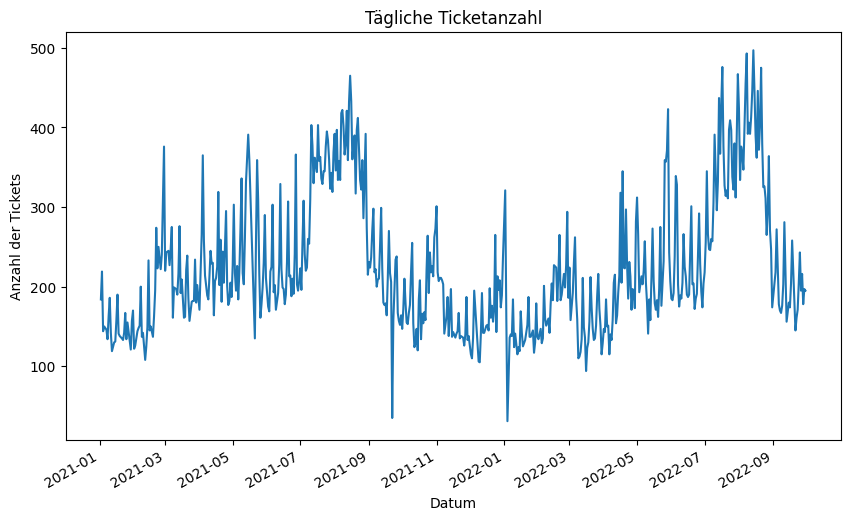

In [36]:
#Ticketanzahl pro Tag
tickets_per_day = df_Process.groupby('date')['ticket_number'].nunique()
tickets_per_day.plot(title='Tägliche Ticketanzahl', figsize=(10, 6))
plt.xlabel('Datum')
plt.ylabel('Anzahl der Tickets')
plt.show()

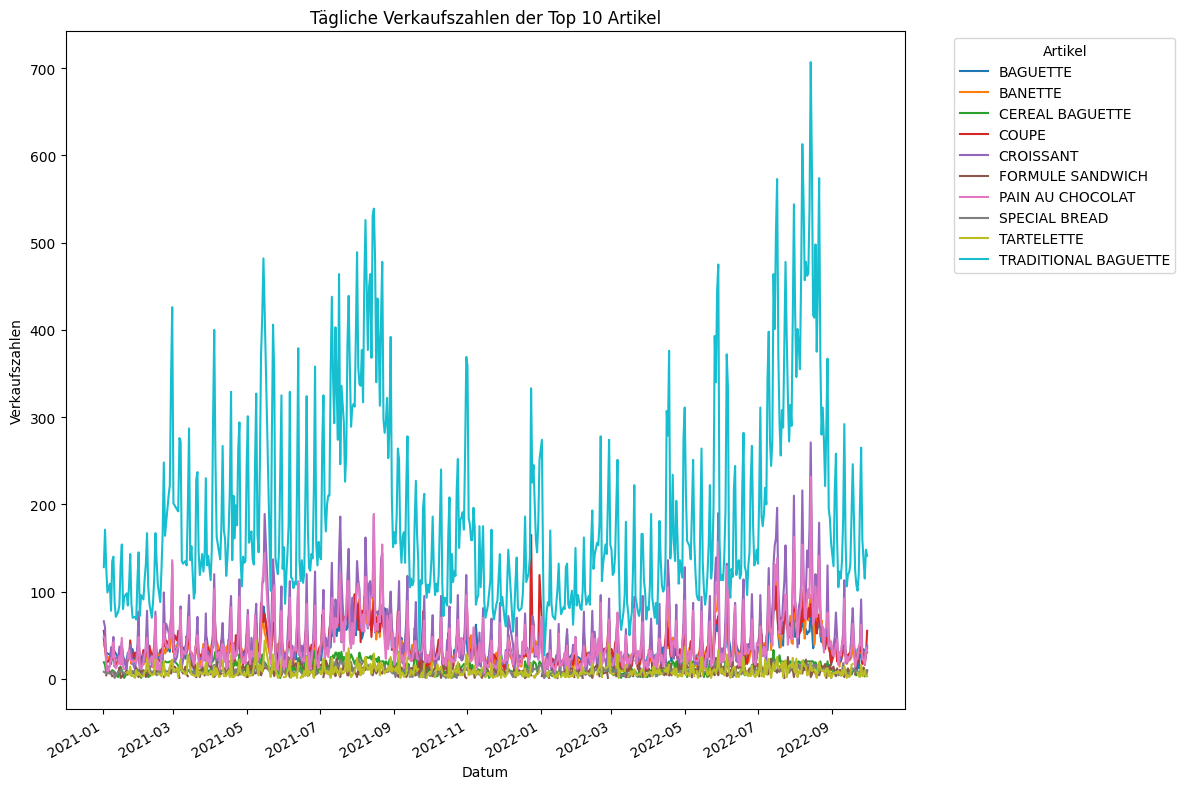

In [37]:
# Verkaufszahlen für die Top 10 Artikel pro Tag (Tabellarisch und Diagramm)
top_10_articles = df_Process.groupby('article')['Quantity'].sum().nlargest(10).index
articles_daily_sales = df_Process[df_Process['article'].isin(top_10_articles)].groupby(['date', 'article'])['Quantity'].sum().unstack()


articles_daily_sales.plot(kind='line', title='Tägliche Verkaufszahlen der Top 10 Artikel', figsize=(12, 8))
plt.xlabel('Datum')
plt.ylabel('Verkaufszahlen')
plt.legend(title='Artikel', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [38]:
# 5. Verkaufszahlen für jeden Artikel pro Tag (Tabellarisch)
articles_daily_sales = df_Process.groupby(['article'])['Quantity'].sum()
articles_daily_sales

,Quantity
article,
.,7.0
12 MACARON,70.0
ARMORICAIN,3.0
ARTICLE 295,1.0
BAGUETTE,22053.0
...,...
TROPEZIENNE,508.0
TROPEZIENNE FRAMBOISE,33.0
TULIPE,2.0


# Datenvorebereitung

In [39]:

def check_stationarity(time_series):
    result = adfuller(time_series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    if result[1] > 0.05:
        print("Die Zeitreihe ist nicht stationär.")
    else:
        print("Die Zeitreihe ist stationär.")

In [40]:
# Überprüfung der Stationarität
print("Stationarität der Originalzeitreihe:")
check_stationarity(daily_revenue.dropna())

Stationarität der Originalzeitreihe:
ADF Statistic: -3.12940476781708
p-value: 0.02445225873218421
Critical Values: {'1%': -3.4415777369651717, '5%': -2.866493255736561, '10%': -2.569407951640003}
Die Zeitreihe ist stationär.


In [41]:
df_Process['trend'] = daily_revenue.rolling(window=30, center=True).mean()

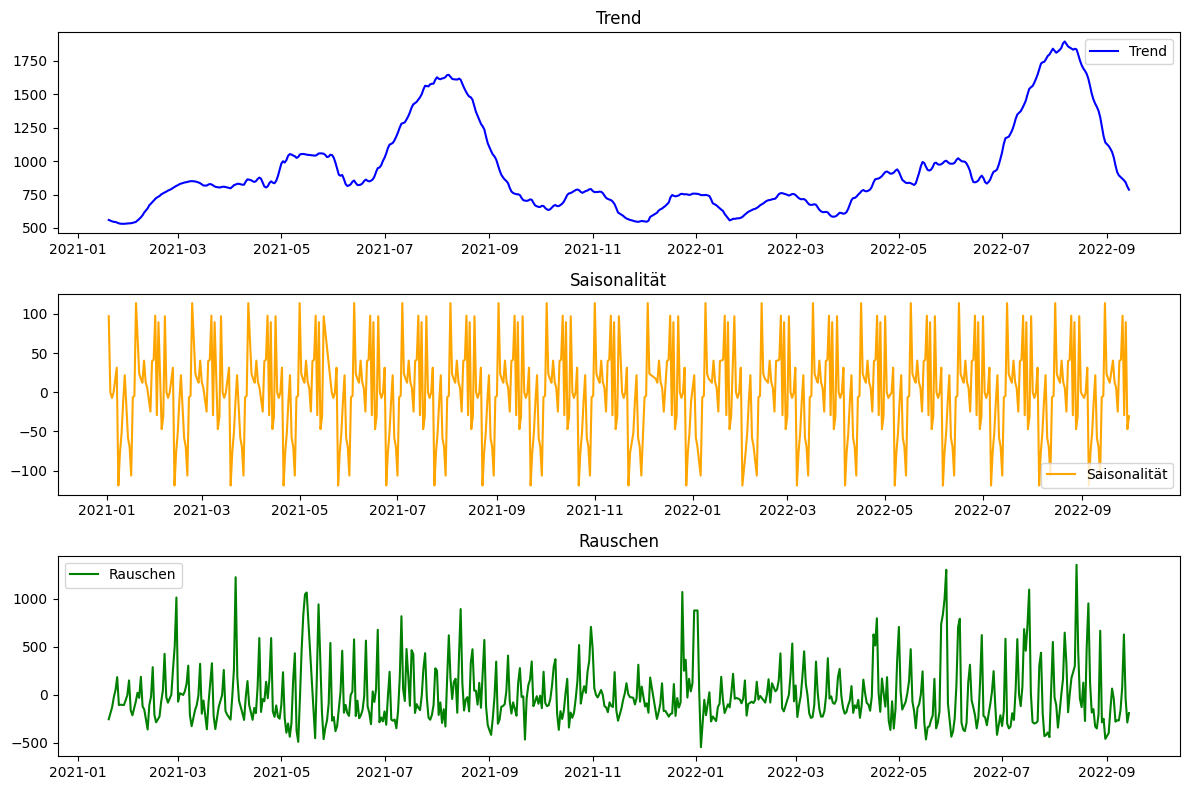

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Zeitreihenanalyse
decomposition = seasonal_decompose(daily_revenue, model='additive', period=30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Trend und Saisonalität anzeigen
plt.figure(figsize=(12, 8))
plt.subplot(311)
plt.plot(trend, label='Trend', color='blue')
plt.title('Trend')
plt.legend()

plt.subplot(312)
plt.plot(seasonal, label='Saisonalität', color='orange')
plt.title('Saisonalität')
plt.legend()

plt.subplot(313)
plt.plot(residual, label='Rauschen', color='green')
plt.title('Rauschen')
plt.legend()

plt.tight_layout()
plt.show()


In [43]:
# Varianz und Mittelwert von Saisonalität und Trend

print("Mittelwert der Saisonalität:", seasonal.mean())


Mittelwert der Saisonalität: -1.4210854715202004e-16


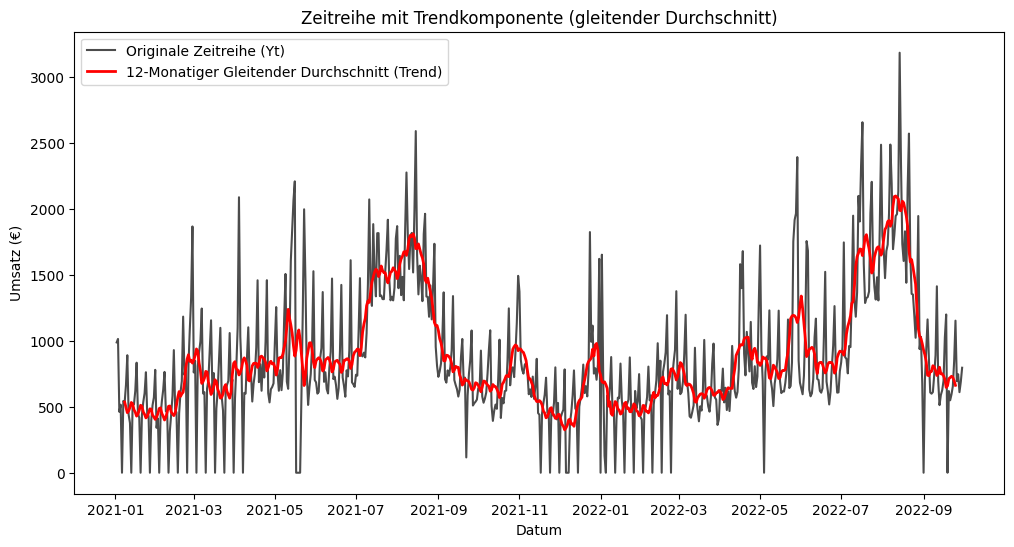

In [44]:
#Decomposition

# Daten vorbereiten
df_bakery_raw = df_bakery_raw.copy()

# Einheitspreise und Mengen bereinigen
df_bakery_raw['unit_price'] = df_bakery_raw['unit_price'].str.replace(',', '.').str.replace(' €', '').astype(float)
df_bakery_raw['Quantity'] = df_bakery_raw['Quantity'].astype(float)

# Umsatz pro Transaktion berechnen
df_bakery_raw['revenue'] = df_bakery_raw['Quantity'] * df_bakery_raw['unit_price']

# Umsatz pro Tag aggregieren
daily_revenue = df_bakery_raw.groupby('date')['revenue'].sum().reset_index()
daily_revenue['date'] = pd.to_datetime(daily_revenue['date'])
daily_revenue.set_index('date', inplace=True)
daily_revenue = daily_revenue.asfreq('D').fillna(0)

# Gleitender Durchschnitt für Trendermittlung
window_size = 12  # Fenstergröße für gleitenden Durchschnitt
trend_k_moving_avg = daily_revenue['revenue'].rolling(window=window_size, center=True).mean()

# Plot der Zeitreihe und des Trends
plt.figure(figsize=(12, 6))
plt.plot(daily_revenue['revenue'], label='Originale Zeitreihe (Yt)', color='black', alpha=0.7)
plt.plot(trend_k_moving_avg, label=f'{window_size}-Monatiger Gleitender Durchschnitt (Trend)', color='red', linewidth=2)
plt.title('Zeitreihe mit Trendkomponente (gleitender Durchschnitt)')
plt.xlabel('Datum')
plt.ylabel('Umsatz (€)')
plt.legend()
plt.show()

# Modelle

### ARIMA

ADF Statistic: -2.655863245165528
p-value: 0.08199216288481259
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9260.339, Time=2.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9410.758, Time=0.07 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9374.716, Time=0.16 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9337.908, Time=1.62 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9408.759, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9258.831, Time=5.96 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9371.134, Time=0.52 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=9218.348, Time=6.33 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=9347.689, Time=0.54 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=9167.700, Time=9.95 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=9264.665, Time=1.88 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=9142.280, Time=4.47 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=9198.582, Time=0.32 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=9016.680, Time=2.13 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=9146.879, Time=3.00 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=4.24 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=9068.672, Time=2.38 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(0,0,0)[0]             : AIC=9014.667, Time=1.28 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0]             : AIC=9144.859, Time=0.68 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,0)[0]             : AIC=9140.286, Time=0.56 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,3)(0,0,0)[0]             : AIC=inf, Time=2.30 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0]             : AIC=9165.707, Time=0.47 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[0]             : AIC=9065.496, Time=5.05 sec

Best model:  ARIMA(5,1,2)(0,0,0)[0]          
Total fit time: 56.143 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


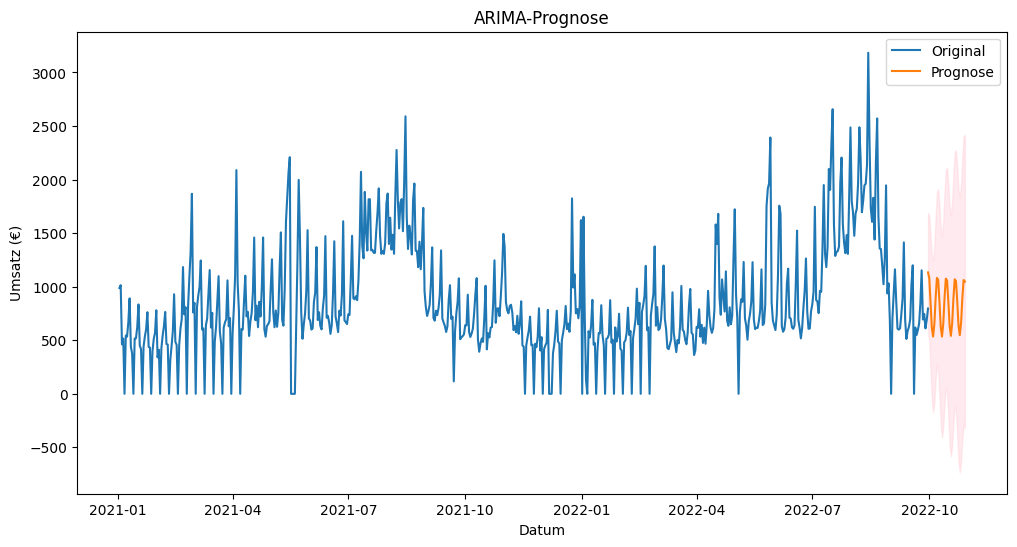

In [45]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller, acf, q_stat

# Sicherstellen, dass die Zeitreihe stationär ist
adf_test = adfuller(daily_revenue.dropna())
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])

# Falls nicht stationär, Differenzbildung durchführen
if adf_test[1] > 0.05:
    daily_revenue_diff = daily_revenue.diff().dropna()
else:
    daily_revenue_diff = daily_revenue

# Optimalen ARIMA-Parameter mit auto_arima finden
stepwise_model = auto_arima(daily_revenue,
                            start_p=1, start_q=1,
                            max_p=5, max_q=5,
                            seasonal=False, trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)



# ARIMA-Modell mit den gefundenen Parametern trainieren
order = stepwise_model.order
arima_model = ARIMA(daily_revenue, order=order)
arima_result = arima_model.fit()


# Prognose erstellen
forecast = arima_result.get_forecast(steps=30)
forecast_index = pd.date_range(daily_revenue.index[-1], periods=30, freq='D')
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Ergebnisse visualisieren
plt.figure(figsize=(12, 6))
plt.plot(daily_revenue, label='Original')
plt.plot(forecast_index, forecast_mean, label='Prognose')
plt.fill_between(forecast_index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1],
                 color='pink', alpha=0.3)
plt.title('ARIMA-Prognose')
plt.xlabel('Datum')
plt.ylabel('Umsatz (€)')
plt.legend()
plt.show()


Mean Absolute Error (MAE): 554.65


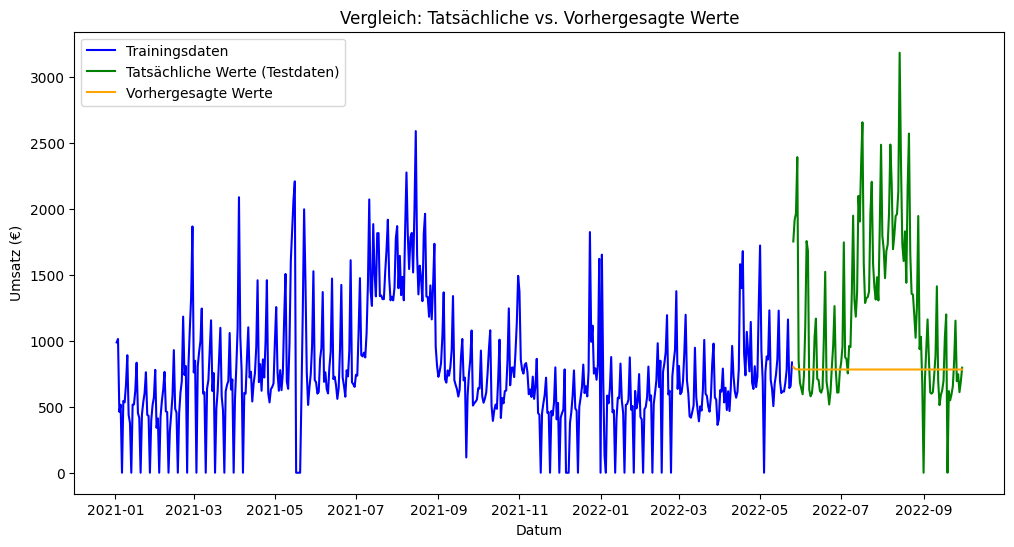

In [46]:
# Frequenz setzen
daily_revenue = daily_revenue.asfreq('D')

# Train-Test-Split
train_size = int(len(daily_revenue) * 0.8)
train, test = daily_revenue.iloc[:train_size], daily_revenue.iloc[train_size:]

# Einfacheres ARIMA-Modell
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(train, order=(1, 1, 1))
arima_result = arima_model.fit()

# Vorhersage erstellen
predictions = arima_result.predict(start=test.index[0], end=test.index[-1])

# Fehlende Werte auffüllen
predictions = predictions.bfill()
test = test.dropna()

# Übereinstimmenden Index sicherstellen
common_index = test.index.intersection(predictions.index)
test = test.loc[common_index]
predictions = predictions.loc[common_index]

# MAE berechnen
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test, predictions)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Visualisierung
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(train, label='Trainingsdaten', color='blue')
plt.plot(test, label='Tatsächliche Werte (Testdaten)', color='green')
plt.plot(predictions, label='Vorhergesagte Werte', color='orange')
plt.title('Vergleich: Tatsächliche vs. Vorhergesagte Werte')
plt.xlabel('Datum')
plt.ylabel('Umsatz (€)')
plt.legend()
plt.show()


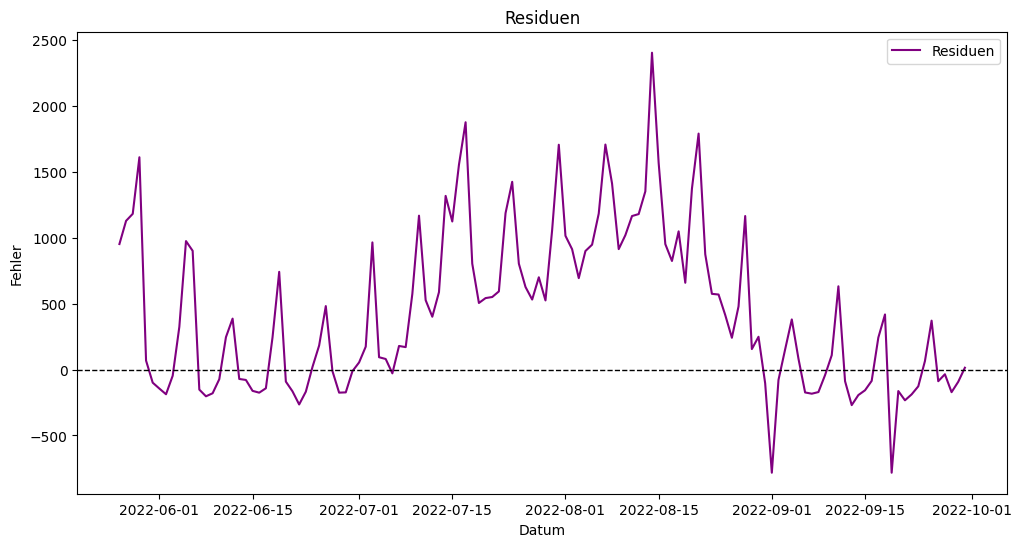

Ljung-Box-Test Ergebnisse:
      lb_stat     lb_pvalue
10  370.97877  1.397862e-73
Die Residuen zeigen Autokorrelation (kein white noise).

Augmented Dickey-Fuller-Test Ergebnisse:
ADF-Statistik: -1.6587596318193083
p-Wert: 0.45247611775077756
Kritische Werte: {'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}
Die Residuen sind nicht stationär.


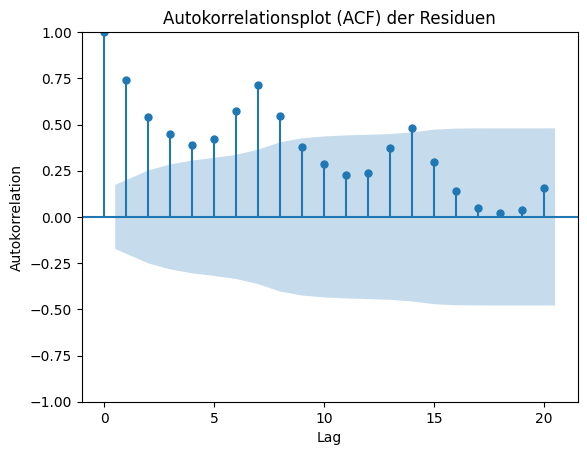

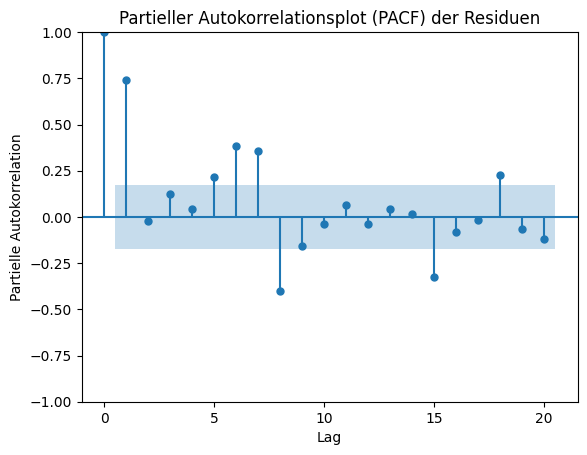

In [47]:
# Residuen berechnen
residuals = test.squeeze() - predictions.squeeze()

# Sicherstellen, dass die Indizes übereinstimmen
common_index = test.index.intersection(predictions.index)
test = test.loc[common_index]
predictions = predictions.loc[common_index]

# Residuen plotten
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuen', color='purple')
plt.axhline(0, linestyle='--', color='black', linewidth=1)
plt.title('Residuen')
plt.xlabel('Datum')
plt.ylabel('Fehler')
plt.legend()
plt.show()

# Ljung-Box-Test für White Noise
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(residuals.dropna(), lags=[10], return_df=True)
print("Ljung-Box-Test Ergebnisse:")
print(lb_test)

if lb_test['lb_pvalue'].iloc[-1] > 0.05:
    print("Die Residuen sind weißes Rauschen (white noise).")
else:
    print("Die Residuen zeigen Autokorrelation (kein white noise).")

# Augmented Dickey-Fuller-Test für Stationarität
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(residuals.dropna())
print("\nAugmented Dickey-Fuller-Test Ergebnisse:")
print(f"ADF-Statistik: {adf_test[0]}")
print(f"p-Wert: {adf_test[1]}")
print("Kritische Werte:", adf_test[4])

if adf_test[1] > 0.05:
    print("Die Residuen sind nicht stationär.")
else:
    print("Die Residuen sind stationär.")

# Autokorrelationsplots (ACF und PACF)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Autokorrelationsplot (ACF)
plot_acf(residuals.dropna(), lags=20)
plt.title('Autokorrelationsplot (ACF) der Residuen')
plt.xlabel('Lag')
plt.ylabel('Autokorrelation')
plt.show()

# Partieller Autokorrelationsplot (PACF)
plot_pacf(residuals.dropna(), lags=20, method='ywm')
plt.title('Partieller Autokorrelationsplot (PACF) der Residuen')
plt.xlabel('Lag')
plt.ylabel('Partielle Autokorrelation')
plt.show()


Das Residuum ist weder stationär noch white noise. Es zeigt klare periodische Muster und Autokorrelationen.
Dies bedeutet, dass das aktuelle ARIMA-Modell die Daten nicht vollständig beschreibt. Eine Verbesserung des Modells ist notwendig.

### SARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Absolute Error (MAE) SARIMA: 551.23


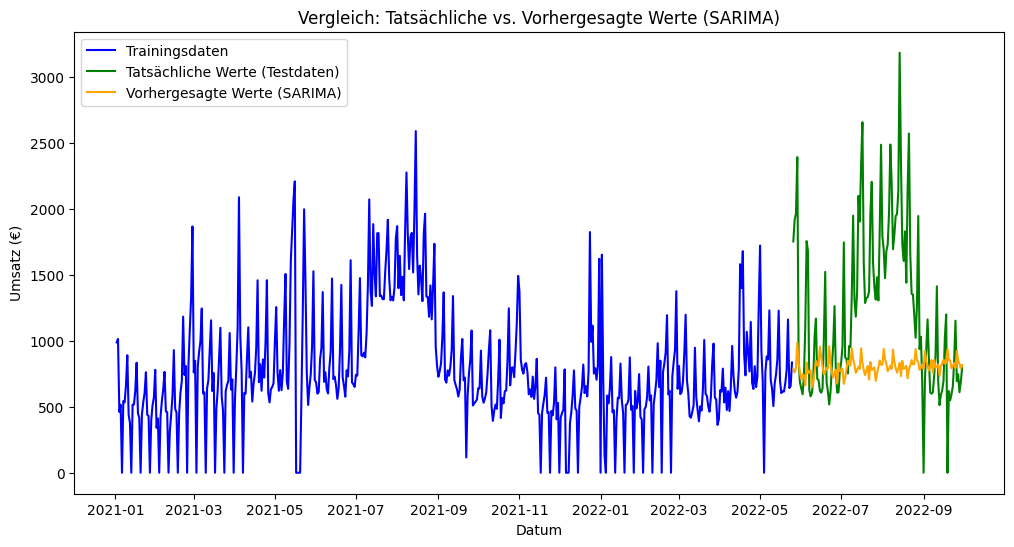

In [48]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# Train-Test-Split
train_size = int(len(daily_revenue) * 0.8)
train, test = daily_revenue.iloc[:train_size], daily_revenue.iloc[train_size:]

# SARIMA-Modell trainieren
sarima_model = SARIMAX(train,
                       order=(1, 1, 1),
                       seasonal_order=(2, 1, 2, 12))
sarima_result = sarima_model.fit()

# Vorhersage erstellen
start = test.index[0]
end = test.index[-1]
sarima_predictions = sarima_result.predict(start=start, end=end)

# Fehlende Werte behandeln
sarima_predictions = sarima_predictions.bfill()  # Rückwärtsauffüllen
test = test.dropna()  # NaN-Werte entfernen

# Sicherstellen, dass die Längen übereinstimmen
common_index = test.index.intersection(sarima_predictions.index)
test = test.loc[common_index]
sarima_predictions = sarima_predictions.loc[common_index]

# MAE berechnen
mae_sarima = mean_absolute_error(test, sarima_predictions)
print(f"Mean Absolute Error (MAE) SARIMA: {mae_sarima:.2f}")

# Visualisierung
plt.figure(figsize=(12, 6))
plt.plot(train, label='Trainingsdaten', color='blue')
plt.plot(test, label='Tatsächliche Werte (Testdaten)', color='green')
plt.plot(sarima_predictions, label='Vorhergesagte Werte (SARIMA)', color='orange')
plt.title('Vergleich: Tatsächliche vs. Vorhergesagte Werte (SARIMA)')
plt.xlabel('Datum')
plt.ylabel('Umsatz (€)')
plt.legend()
plt.show()


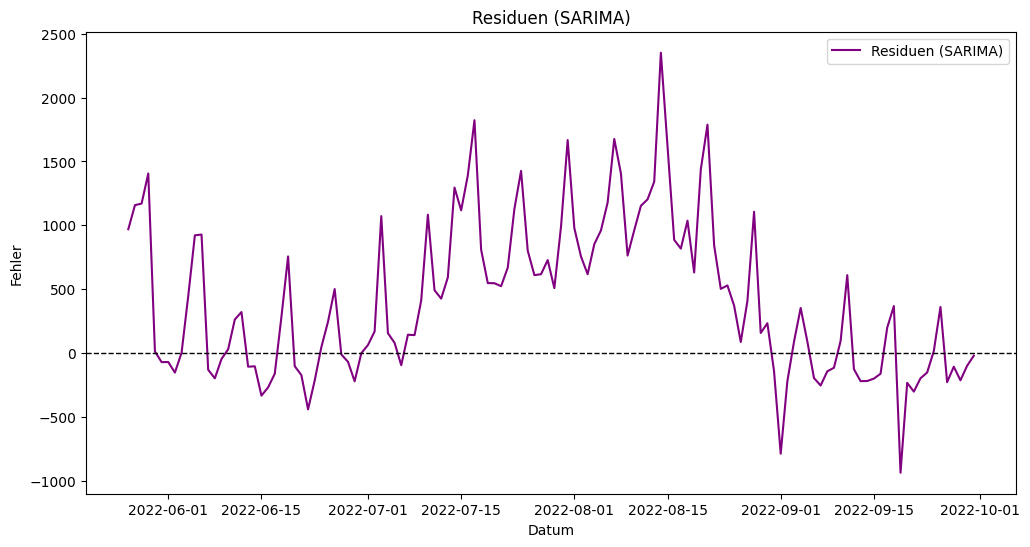

Ljung-Box-Test Ergebnisse (SARIMA):
       lb_stat     lb_pvalue
10  369.945054  2.317992e-73
Die Residuen (SARIMA) zeigen Autokorrelation (kein white noise).

Augmented Dickey-Fuller-Test Ergebnisse (SARIMA):
ADF-Statistik: -1.5979352041553754
p-Wert: 0.4846306118092662
Kritische Werte: {'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}
Die Residuen (SARIMA) sind nicht stationär.


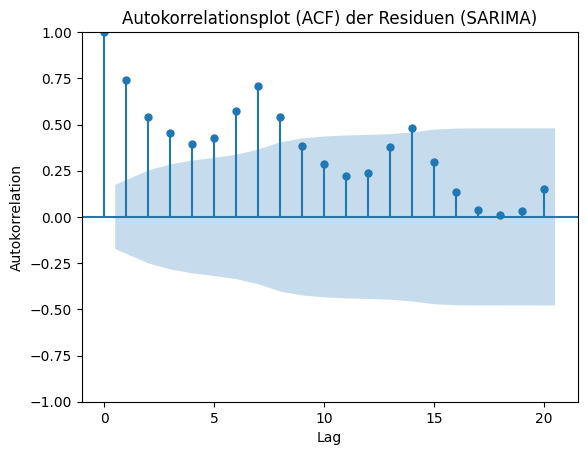

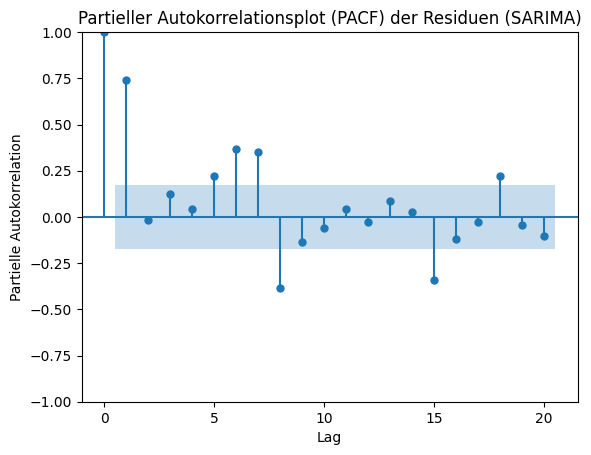

In [49]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Residuen berechnen
sarima_residuals = test.squeeze() - sarima_predictions.squeeze()

# Residuen plotten
plt.figure(figsize=(12, 6))
plt.plot(sarima_residuals, label='Residuen (SARIMA)', color='purple')
plt.axhline(0, linestyle='--', color='black', linewidth=1)
plt.title('Residuen (SARIMA)')
plt.xlabel('Datum')
plt.ylabel('Fehler')
plt.legend()
plt.show()

# 1. Ljung-Box-Test für White Noise
lb_test_sarima = acorr_ljungbox(sarima_residuals.dropna(), lags=[10], return_df=True)
print("Ljung-Box-Test Ergebnisse (SARIMA):")
print(lb_test_sarima)

if lb_test_sarima['lb_pvalue'].iloc[-1] > 0.05:
    print("Die Residuen (SARIMA) sind weißes Rauschen (white noise).")
else:
    print("Die Residuen (SARIMA) zeigen Autokorrelation (kein white noise).")

# 2. Augmented Dickey-Fuller-Test (ADF) für Stationarität
adf_test_sarima = adfuller(sarima_residuals.dropna())
print("\nAugmented Dickey-Fuller-Test Ergebnisse (SARIMA):")
print(f"ADF-Statistik: {adf_test_sarima[0]}")
print(f"p-Wert: {adf_test_sarima[1]}")
print("Kritische Werte:", adf_test_sarima[4])

if adf_test_sarima[1] > 0.05:
    print("Die Residuen (SARIMA) sind nicht stationär.")
else:
    print("Die Residuen (SARIMA) sind stationär.")

# 3. Autokorrelationsplots (ACF und PACF)
# Autokorrelationsplot (ACF)
plot_acf(sarima_residuals.dropna(), lags=20)
plt.title('Autokorrelationsplot (ACF) der Residuen (SARIMA)')
plt.xlabel('Lag')
plt.ylabel('Autokorrelation')
plt.show()

# Partieller Autokorrelationsplot (PACF)
plot_pacf(sarima_residuals.dropna(), lags=20, method='ywm')
plt.title('Partieller Autokorrelationsplot (PACF) der Residuen (SARIMA)')
plt.xlabel('Lag')
plt.ylabel('Partielle Autokorrelation')
plt.show()


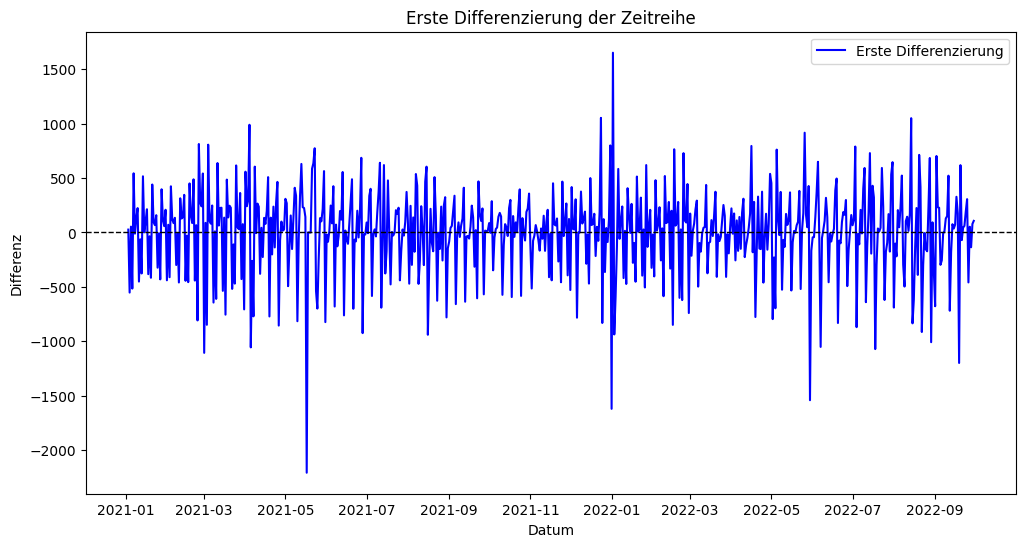

ADF Statistic (Differenzierung): -5.7485994861299785
p-value (Differenzierung): 6.039751047598484e-07
Critical Values (Differenzierung): {'1%': -3.4410277306083668, '5%': -2.8662510413264357, '10%': -2.569278890210853}
Die differenzierte Zeitreihe ist stationär.


In [50]:
# Erste Differenzierung durchführen
diff_1 = daily_revenue.diff().dropna()

# Plot der differenzierten Zeitreihe
plt.figure(figsize=(12, 6))
plt.plot(diff_1, label='Erste Differenzierung', color='blue')
plt.axhline(0, linestyle='--', color='black', linewidth=1)
plt.title('Erste Differenzierung der Zeitreihe')
plt.xlabel('Datum')
plt.ylabel('Differenz')
plt.legend()
plt.show()

# ADF-Test für die differenzierte Zeitreihe
adf_test_diff_1 = adfuller(diff_1)
print("ADF Statistic (Differenzierung):", adf_test_diff_1[0])
print("p-value (Differenzierung):", adf_test_diff_1[1])
print("Critical Values (Differenzierung):", adf_test_diff_1[4])

if adf_test_diff_1[1] > 0.05:
    print("Die differenzierte Zeitreihe ist nicht stationär.")
else:
    print("Die differenzierte Zeitreihe ist stationär.")


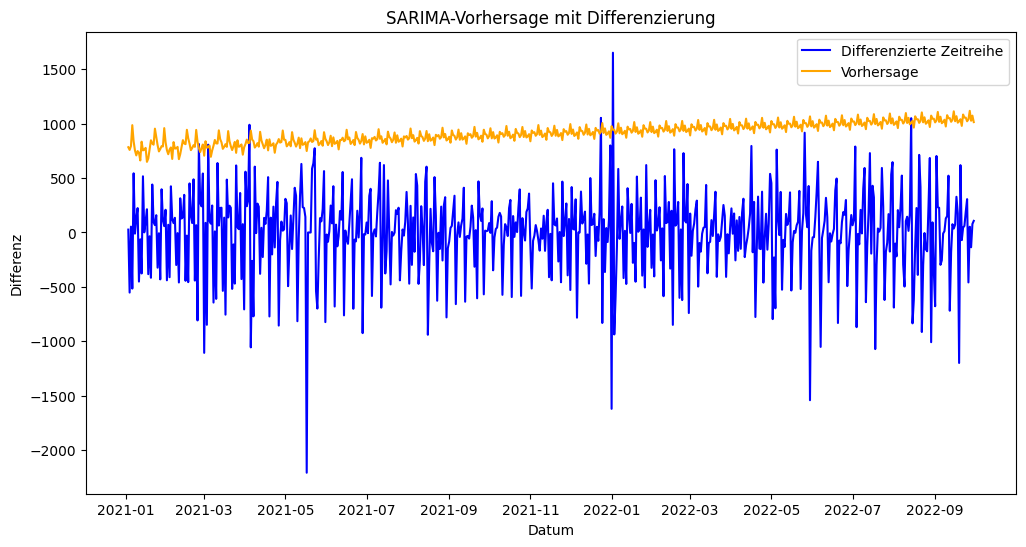

In [51]:
forecast = sarima_result.get_forecast(steps=len(diff_1))
forecast_values = forecast.predicted_mean

# Plot der Vorhersage
plt.figure(figsize=(12, 6))
plt.plot(diff_1, label='Differenzierte Zeitreihe', color='blue')
plt.plot(diff_1.index, forecast_values, label='Vorhersage', color='orange')
plt.title('SARIMA-Vorhersage mit Differenzierung')
plt.xlabel('Datum')
plt.ylabel('Differenz')
plt.legend()
plt.show()


### Hinzufügen von Features

In [52]:
df_bakery_raw

,Unnamed: 0,date,time,ticket_number,article,Quantity,unit_price,revenue
0,0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,0.90,0.90
1,1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,1.20,3.60
2,4,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,1.20,2.40
3,5,2021-01-02,09:14,150041.0,PAIN,1.0,1.15,1.15
4,8,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,1.20,6.00
...,...,...,...,...,...,...,...,...
234000,511387,2022-09-30,18:52,288911.0,COUPE,1.0,0.15,0.15
234001,511388,2022-09-30,18:52,288911.0,BOULE 200G,1.0,1.20,1.20
234002,511389,2022-09-30,18:52,288911.0,COUPE,2.0,0.15,0.30
234003,511392,2022-09-30,18:55,288912.0,TRADITIONAL BAGUETTE,1.0,1.30,1.30


In [53]:

from pytrends.request import TrendReq


df_bakery_raw['date'] = pd.to_datetime(df_bakery_raw['date'])

# Bestimme das Start- und Enddatum aus df_bakery_raw
start_date = df_bakery_raw['date'].min().strftime('%Y-%m-%d')
end_date = df_bakery_raw['date'].max().strftime('%Y-%m-%d')

print("Startdatum:", start_date)
print("Enddatum:", end_date)

# Pytrends-Objekt erstellen
pytrends = TrendReq()



# Interesse an "Brot" abfragen
pytrends.build_payload(kw_list=["bread"], timeframe=f'{start_date} {end_date}')
trends_data = pytrends.interest_over_time()

# Google-Trends-Daten hinzufügen
daily_revenue['google_trends_bread'] = trends_data['bread'].reindex(daily_revenue.index, fill_value=0)

daily_revenue


Startdatum: 2021-01-02
Enddatum: 2022-09-30


,revenue,google_trends_bread
date,,
2021-01-02,987.85,0
2021-01-03,1014.30,91
2021-01-04,461.90,0
2021-01-05,515.70,0
2021-01-06,0.00,0
...,...,...
2022-09-26,693.75,0
2022-09-27,746.45,0
2022-09-28,610.70,0


In [54]:
import yfinance as yf

# Zuckerpreis abrufen (ICE Sugar No. 11 Futures)
sugar_price = yf.download("SB=F", start="2020-01-01", end="2023-12-31")

# Die ersten Zeilen des Datensatzes anzeigen
print(sugar_price.head())


[*********************100%***********************]  1 of 1 completed

Price      Adj Close  Close   High    Low   Open  Volume
Ticker          SB=F   SB=F   SB=F   SB=F   SB=F    SB=F
Date                                                    
2020-01-02     13.13  13.13  13.53  13.10  13.47   84015
2020-01-03     13.31  13.31  13.40  13.20  13.23   63589
2020-01-06     13.73  13.73  13.76  13.37  13.37  101231
2020-01-07     13.59  13.59  13.79  13.55  13.75   67177
2020-01-08     13.47  13.47  13.74  13.41  13.69   74101


In [55]:
# Index der Zuckerpreise in datetime konvertieren
sugar_price.index = pd.to_datetime(sugar_price.index)

# Index des daily_revenue-DataFrames ebenfalls in datetime konvertieren
daily_revenue.index = pd.to_datetime(daily_revenue.index)

# Nur die 'Close'-Spalte der Zuckerpreise verwenden
daily_revenue['sugar_price'] = sugar_price['Close'].reindex(daily_revenue.index, method='nearest')

# Überprüfung der Integration
daily_revenue


,revenue,google_trends_bread,sugar_price
date,,,
2021-01-02,987.85,0,15.760000
2021-01-03,1014.30,91,15.760000
2021-01-04,461.90,0,15.760000
2021-01-05,515.70,0,16.120001
2021-01-06,0.00,0,16.250000
...,...,...,...
2022-09-26,693.75,0,18.350000
2022-09-27,746.45,0,18.190001
2022-09-28,610.70,0,18.290001


In [56]:
# Korrelation prüfen

In [57]:
# Berechnung der Korrelation zwischen allen Spalten
correlation_matrix = daily_revenue.corr()

# Ausgabe der Korrelationstabelle
print("Korrelationstabelle:")
print(correlation_matrix)

# Spezifische Korrelationen prüfen
print("\nKorrelationen:")
print(f"Korrelation zwischen revenue und sugar_price: {correlation_matrix.loc['revenue', 'sugar_price']:.2f}")
print(f"Korrelation zwischen revenue und google_trends_bread: {correlation_matrix.loc['revenue', 'google_trends_bread']:.2f}")
print(f"Korrelation zwischen sugar_price und google_trends_bread: {correlation_matrix.loc['sugar_price', 'google_trends_bread']:.2f}")


Korrelationstabelle:
                      revenue  google_trends_bread  sugar_price
revenue              1.000000             0.390891     0.076628
google_trends_bread  0.390891             1.000000    -0.022729
sugar_price          0.076628            -0.022729     1.000000

Korrelationen:
Korrelation zwischen revenue und sugar_price: 0.08
Korrelation zwischen revenue und google_trends_bread: 0.39
Korrelation zwischen sugar_price und google_trends_bread: -0.02


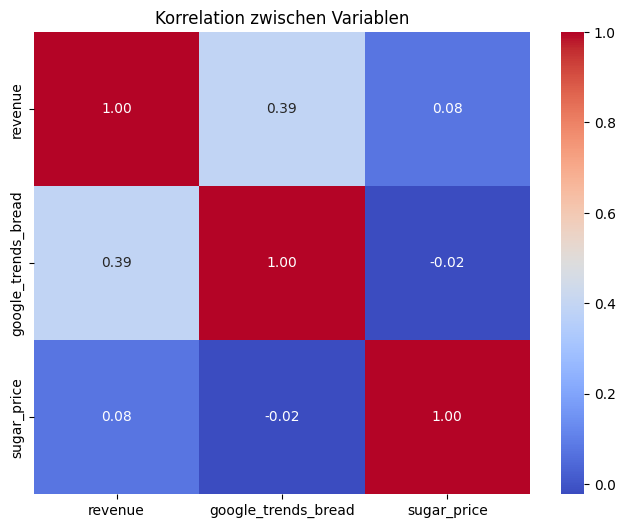

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap der Korrelationen
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Korrelation zwischen Variablen")
plt.show()


In [59]:
# Cranger Cause prüfen

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


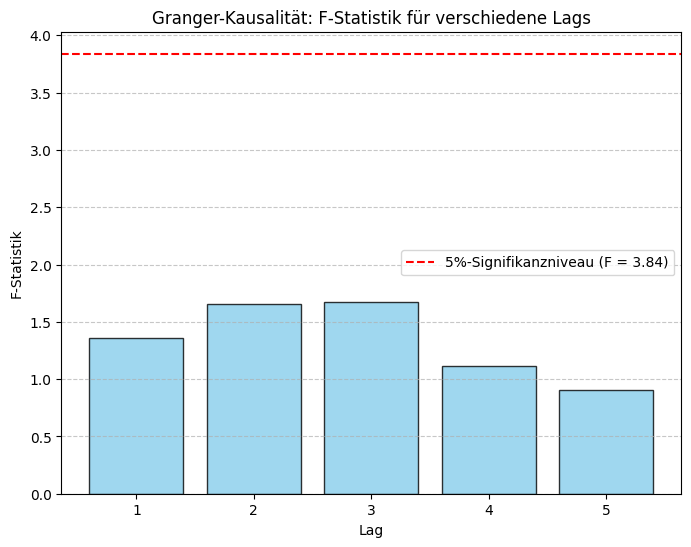

In [60]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# Daten vorbereiten
data = daily_revenue[['revenue', 'sugar_price']].dropna()

# Granger-Cause-Test durchführen
max_lags = 5
granger_result = grangercausalitytests(data, max_lags, verbose=False)

# F-Statistiken extrahieren
f_stats = [granger_result[lag][0]['ssr_ftest'][0] for lag in range(1, max_lags + 1)]

# Balkendiagramm erstellen
plt.figure(figsize=(8, 6))
plt.bar(range(1, max_lags + 1), f_stats, color='skyblue', alpha=0.8, edgecolor='black')
plt.axhline(y=3.84, color='red', linestyle='--', label="5%-Signifikanzniveau (F = 3.84)")
plt.title("Granger-Kausalität: F-Statistik für verschiedene Lags")
plt.xlabel("Lag")
plt.ylabel("F-Statistik")
plt.xticks(range(1, max_lags + 1))
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [61]:
df_bakery_raw

,Unnamed: 0,date,time,ticket_number,article,Quantity,unit_price,revenue
0,0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,0.90,0.90
1,1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,1.20,3.60
2,4,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,1.20,2.40
3,5,2021-01-02,09:14,150041.0,PAIN,1.0,1.15,1.15
4,8,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,1.20,6.00
...,...,...,...,...,...,...,...,...
234000,511387,2022-09-30,18:52,288911.0,COUPE,1.0,0.15,0.15
234001,511388,2022-09-30,18:52,288911.0,BOULE 200G,1.0,1.20,1.20
234002,511389,2022-09-30,18:52,288911.0,COUPE,2.0,0.15,0.30
234003,511392,2022-09-30,18:55,288912.0,TRADITIONAL BAGUETTE,1.0,1.30,1.30


### Einzelne Article als Feature

In [62]:
# Top 10 Artikel basierend auf dem Gesamtumsatz berechnen
top_articles = (
    df_bakery_raw.groupby('article')['revenue']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# Filtern der Daten für Top 10 Artikel
filtered_data = df_bakery_raw[df_bakery_raw['article'].isin(top_articles)]

# Aggregation: Umsatz und Anzahl pro Artikel und Tag
article_aggregation = (
    filtered_data.groupby(['date', 'article'])
    .agg(total_quantity=('Quantity', 'sum'), total_revenue=('revenue', 'sum'))
    .reset_index()
)

# Pivot-Tabelle erstellen
pivot_table = article_aggregation.pivot_table(
    index='date',
    columns='article',
    values=['total_quantity', 'total_revenue'],
    fill_value=0
)

# Spalten umbenennen für Klarheit
pivot_table.columns = ['_'.join(col).strip() for col in pivot_table.columns]

# Zurück zu DataFrame-Format
pivot_table.reset_index(inplace=True)

# Zusammenführen mit daily_revenue
daily_revenue = pd.merge(daily_revenue, pivot_table, on='date', how='left')

# Ergebnisse überprüfen
daily_revenue


,date,revenue,google_trends_bread,sugar_price,total_quantity_BAGUETTE,total_quantity_BANETTE,total_quantity_CROISSANT,total_quantity_FORMULE SANDWICH,total_quantity_GRAND FAR BRETON,total_quantity_PAIN AU CHOCOLAT,...,total_revenue_BAGUETTE,total_revenue_BANETTE,total_revenue_CROISSANT,total_revenue_FORMULE SANDWICH,total_revenue_GRAND FAR BRETON,total_revenue_PAIN AU CHOCOLAT,total_revenue_SANDWICH COMPLET,total_revenue_SPECIAL BREAD,total_revenue_TRADITIONAL BAGUETTE,total_revenue_TRAITEUR
0,2021-01-02,987.85,0,15.760000,46.0,40.0,66.0,0.0,6.0,48.0,...,41.4,42.00,72.6,0.0,42.0,57.6,9.0,19.2,153.6,0.0
1,2021-01-03,1014.30,91,15.760000,35.0,35.0,59.0,0.0,2.0,45.0,...,31.5,36.75,64.9,0.0,14.0,54.0,0.0,16.8,205.2,0.0
2,2021-01-04,461.90,0,15.760000,30.0,24.0,17.0,4.0,1.0,17.0,...,27.0,25.20,18.7,26.0,7.0,20.4,18.0,16.8,153.6,0.0
3,2021-01-05,515.70,0,16.120001,29.0,26.0,12.0,12.0,0.0,6.0,...,26.1,27.30,13.2,78.0,0.0,7.2,22.5,16.8,118.8,0.0
4,2021-01-06,0.00,0,16.250000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,2022-09-26,693.75,0,18.350000,18.0,30.0,26.0,6.0,0.0,22.0,...,18.0,34.50,31.2,42.0,0.0,28.6,25.0,18.2,208.0,54.6
633,2022-09-27,746.45,0,18.190001,34.0,30.0,25.0,13.0,0.0,22.0,...,34.0,34.50,30.0,91.0,0.0,28.6,50.0,20.8,176.8,37.1
634,2022-09-28,610.70,0,18.290001,23.0,22.0,20.0,9.0,3.0,17.0,...,23.0,25.30,24.0,63.0,22.5,22.1,30.0,26.0,149.5,0.0
635,2022-09-29,689.20,0,18.440001,30.0,30.0,27.0,3.0,1.0,36.0,...,30.0,34.50,32.4,21.0,7.5,46.8,40.0,18.2,192.4,0.0


Korrelationstabelle:
                                         date   revenue  google_trends_bread  \
date                                 1.000000  0.202217            -0.020489   
revenue                              0.202217  1.000000             0.390891   
google_trends_bread                 -0.020489  0.390891             1.000000   
sugar_price                          0.574228  0.076628            -0.022729   
total_quantity_BAGUETTE              0.027932  0.858566             0.405133   
total_quantity_BANETTE               0.074490  0.897032             0.279401   
total_quantity_CROISSANT             0.114668  0.906305             0.570088   
total_quantity_FORMULE SANDWICH      0.061335 -0.120888            -0.463849   
total_quantity_GRAND FAR BRETON      0.094223  0.788849             0.189884   
total_quantity_PAIN AU CHOCOLAT      0.130274  0.903694             0.505496   
total_quantity_SANDWICH COMPLET      0.032603 -0.096721            -0.408035   
total_quantity_SPEC

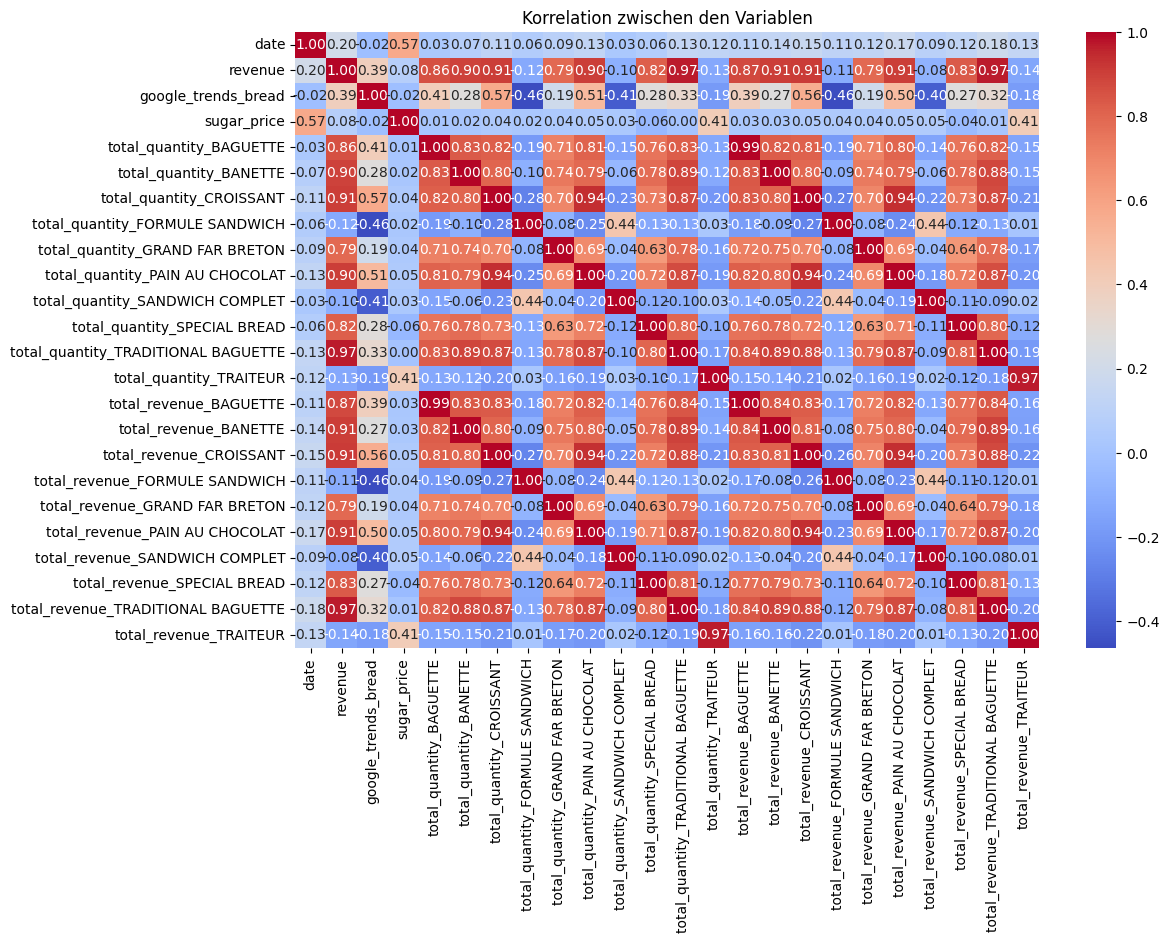

In [63]:
# Berechnung der Korrelationen
correlation_matrix = daily_revenue.corr()

# Korrelationstabelle anzeigen
print("Korrelationstabelle:")
print(correlation_matrix)

# Visualisierung der Korrelationen mit einer Heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Korrelation zwischen den Variablen")
plt.show()


In [64]:
from statsmodels.tsa.stattools import grangercausalitytests

# Ziel- und erklärende Variablen auswählen
max_lags = 5  # Maximale Anzahl der Lags

# Granger-Cause-Test für jeden erklärenden Faktor
features = [col for col in daily_revenue.columns if col.startswith("total_")]
for feature in features:
    print(f"Granger-Cause-Test: {feature} → revenue")
    grangercausalitytests(daily_revenue[['revenue', feature]].dropna(), max_lags, verbose=True)


Granger-Cause-Test: total_quantity_BAGUETTE → revenue

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3022  , p=0.5827  , df_denom=596, df_num=1
ssr based chi2 test:   chi2=0.3037  , p=0.5816  , df=1
likelihood ratio test: chi2=0.3036  , p=0.5816  , df=1
parameter F test:         F=0.3022  , p=0.5827  , df_denom=596, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.7251  , p=0.0247  , df_denom=593, df_num=2
ssr based chi2 test:   chi2=7.5131  , p=0.0234  , df=2
likelihood ratio test: chi2=7.4663  , p=0.0239  , df=2
parameter F test:         F=3.7251  , p=0.0247  , df_denom=593, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2720  , p=0.0792  , df_denom=590, df_num=3
ssr based chi2 test:   chi2=6.8968  , p=0.0753  , df=3
likelihood ratio test: chi2=6.8573  , p=0.0766  , df=3
parameter F test:         F=2.2720  , p=0.0792  , df_denom=590, df_num=3

Granger Causality
number of lags (no ze

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


parameter F test:         F=5.7969  , p=0.0000  , df_denom=584, df_num=5
Granger-Cause-Test: total_quantity_CROISSANT → revenue

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=56.8689 , p=0.0000  , df_denom=596, df_num=1
ssr based chi2 test:   chi2=57.1551 , p=0.0000  , df=1
likelihood ratio test: chi2=54.5903 , p=0.0000  , df=1
parameter F test:         F=56.8689 , p=0.0000  , df_denom=596, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=36.4766 , p=0.0000  , df_denom=593, df_num=2
ssr based chi2 test:   chi2=73.5683 , p=0.0000  , df=2
likelihood ratio test: chi2=69.3830 , p=0.0000  , df=2
parameter F test:         F=36.4766 , p=0.0000  , df_denom=593, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=23.6707 , p=0.0000  , df_denom=590, df_num=3
ssr based chi2 test:   chi2=71.8545 , p=0.0000  , df=3
likelihood ratio test: chi2=67.8487 , p=0.0000  , df=3
parameter F test:         F=23.6707 , p

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ssr based F test:         F=14.2043 , p=0.0000  , df_denom=587, df_num=4
ssr based chi2 test:   chi2=57.6885 , p=0.0000  , df=4
likelihood ratio test: chi2=55.0646 , p=0.0000  , df=4
parameter F test:         F=14.2043 , p=0.0000  , df_denom=587, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=9.5398  , p=0.0000  , df_denom=584, df_num=5
ssr based chi2 test:   chi2=48.5974 , p=0.0000  , df=5
likelihood ratio test: chi2=46.7146 , p=0.0000  , df=5
parameter F test:         F=9.5398  , p=0.0000  , df_denom=584, df_num=5
Granger-Cause-Test: total_quantity_SANDWICH COMPLET → revenue

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.1925 , p=0.0000  , df_denom=596, df_num=1
ssr based chi2 test:   chi2=19.2891 , p=0.0000  , df=1
likelihood ratio test: chi2=18.9851 , p=0.0000  , df=1
parameter F test:         F=19.1925 , p=0.0000  , df_denom=596, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=30.4

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



parameter F test:         F=1.0567  , p=0.3772  , df_denom=587, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.7486  , p=0.5874  , df_denom=584, df_num=5
ssr based chi2 test:   chi2=3.8133  , p=0.5766  , df=5
likelihood ratio test: chi2=3.8012  , p=0.5784  , df=5
parameter F test:         F=0.7486  , p=0.5874  , df_denom=584, df_num=5
Granger-Cause-Test: total_revenue_BAGUETTE → revenue

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0092  , p=0.9238  , df_denom=596, df_num=1
ssr based chi2 test:   chi2=0.0092  , p=0.9235  , df=1
likelihood ratio test: chi2=0.0092  , p=0.9235  , df=1
parameter F test:         F=0.0092  , p=0.9238  , df_denom=596, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6127  , p=0.0742  , df_denom=593, df_num=2
ssr based chi2 test:   chi2=5.2694  , p=0.0717  , df=2
likelihood ratio test: chi2=5.2463  , p=0.0726  , df=2
parameter F test:         F=2.6127  , p=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



ssr based chi2 test:   chi2=73.3667 , p=0.0000  , df=5
likelihood ratio test: chi2=69.1839 , p=0.0000  , df=5
parameter F test:         F=14.4021 , p=0.0000  , df_denom=584, df_num=5
Granger-Cause-Test: total_revenue_GRAND FAR BRETON → revenue

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=23.3305 , p=0.0000  , df_denom=596, df_num=1
ssr based chi2 test:   chi2=23.4480 , p=0.0000  , df=1
likelihood ratio test: chi2=23.0007 , p=0.0000  , df=1
parameter F test:         F=23.3305 , p=0.0000  , df_denom=596, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=14.1721 , p=0.0000  , df_denom=593, df_num=2
ssr based chi2 test:   chi2=28.5831 , p=0.0000  , df=2
likelihood ratio test: chi2=27.9211 , p=0.0000  , df=2
parameter F test:         F=14.1721 , p=0.0000  , df_denom=593, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=11.8121 , p=0.0000  , df_denom=590, df_num=3
ssr based chi2 test:   chi2=35.8

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



ssr based chi2 test:   chi2=18.3590 , p=0.0025  , df=5
likelihood ratio test: chi2=18.0815 , p=0.0028  , df=5
parameter F test:         F=3.6039  , p=0.0032  , df_denom=584, df_num=5
Granger-Cause-Test: total_revenue_TRADITIONAL BAGUETTE → revenue

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=65.4096 , p=0.0000  , df_denom=596, df_num=1
ssr based chi2 test:   chi2=65.7388 , p=0.0000  , df=1
likelihood ratio test: chi2=62.3754 , p=0.0000  , df=1
parameter F test:         F=65.4096 , p=0.0000  , df_denom=596, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=35.3349 , p=0.0000  , df_denom=593, df_num=2
ssr based chi2 test:   chi2=71.2657 , p=0.0000  , df=2
likelihood ratio test: chi2=67.3290 , p=0.0000  , df=2
parameter F test:         F=35.3349 , p=0.0000  , df_denom=593, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=35.8504 , p=0.0000  , df_denom=590, df_num=3
ssr based chi2 test:   chi2=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


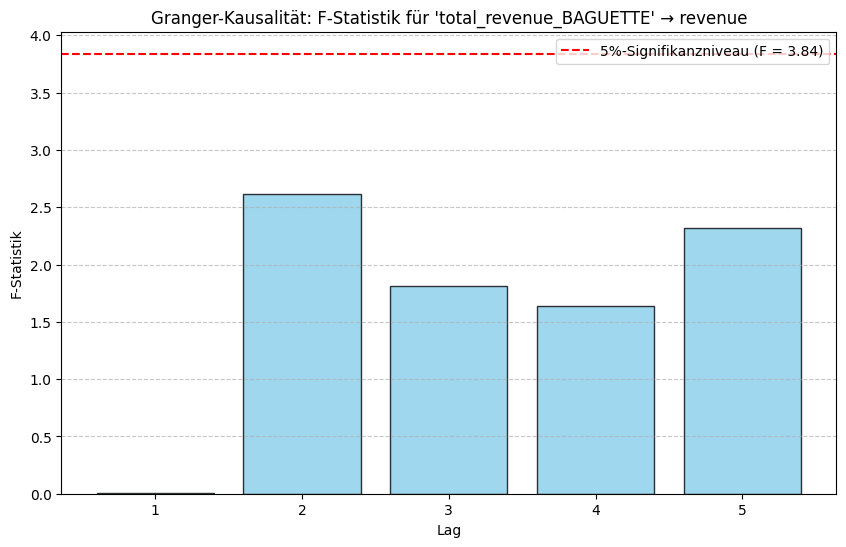

In [65]:
# Beispiel für eine Variable (z. B. `total_revenue_BAGUETTE`)
test_results = grangercausalitytests(daily_revenue[['revenue', 'total_revenue_BAGUETTE']].dropna(), max_lags, verbose=False)

# F-Statistiken extrahieren
f_stats = [test_results[lag][0]['ssr_ftest'][0] for lag in range(1, max_lags + 1)]

# Balkendiagramm erstellen
plt.figure(figsize=(10, 6))
plt.bar(range(1, max_lags + 1), f_stats, color='skyblue', alpha=0.8, edgecolor='black')
plt.axhline(y=3.84, color='red', linestyle='--', label="5%-Signifikanzniveau (F = 3.84)")
plt.title("Granger-Kausalität: F-Statistik für 'total_revenue_BAGUETTE' → revenue")
plt.xlabel("Lag")
plt.ylabel("F-Statistik")
plt.xticks(range(1, max_lags + 1))
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### LSTM

In [69]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# NaN-Werte entfernen
daily_revenue = daily_revenue.dropna()

# Skalieren der Daten
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_revenue.drop(columns=['date']))

# In Features (X) und Zielvariable (y) aufteilen
X = scaled_data[:, 1:]  # Alle Spalten außer 'revenue' (erste Spalte)
y = scaled_data[:, 0]   # 'revenue'

# Zeitfenster (Lagging) erstellen
def create_time_series(X, y, time_steps=10):
    X_lagged, y_lagged = [], []
    for i in range(len(X) - time_steps):
        X_lagged.append(X[i:i+time_steps])
        y_lagged.append(y[i+time_steps])
    return np.array(X_lagged), np.array(y_lagged)

time_steps = 10
X_lagged, y_lagged = create_time_series(X, y, time_steps)

train_size = int(len(X_lagged) * 0.8)  # 80% der Daten für Training
X_train, X_test = X_lagged[:train_size], X_lagged[train_size:]
y_train, y_test = y_lagged[:train_size], y_lagged[train_size:]

In [70]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# LSTM-Modell erstellen
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Modell kompilieren
model.compile(optimizer='adam', loss='mse')

# Modell trainieren
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0373 - val_loss: 0.0378
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0155 - val_loss: 0.0178
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0114 - val_loss: 0.0187
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0126 - val_loss: 0.0211
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0115 - val_loss: 0.0166
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0111 - val_loss: 0.0166
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0117 - val_loss: 0.0159
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0102 - val_loss: 0.0193
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0103 - val_loss: 0.0152
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0105 - val_loss: 0.0138
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0102 - val_loss: 0.0157
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0087 - val_l

In [72]:
# Vorhersagen auf Testdaten
y_pred = model.predict(X_test)

# Skalierten Output zurücktransformieren
y_test_inv = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), X_test[:, -1, :]), axis=1))[:, 0]
y_pred_inv = scaler.inverse_transform(np.concatenate((y_pred, X_test[:, -1, :]), axis=1))[:, 0]

# Fehler berechnen
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Root Mean Squared Error (RMSE): 296.11


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Root Mean Squared Error (RMSE): 296.11


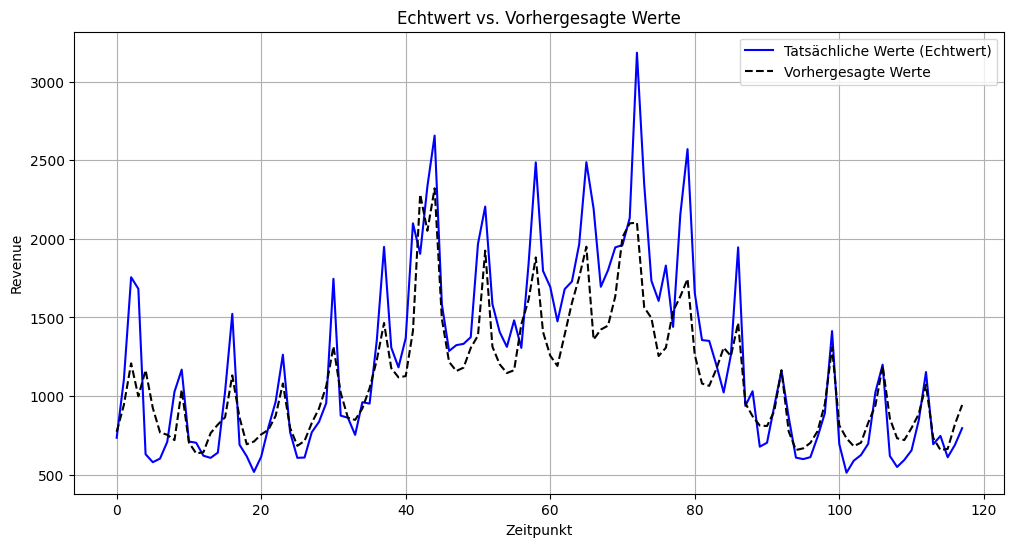

In [74]:
import matplotlib.pyplot as plt

# Vorhersagen auf Testdaten
y_pred = model.predict(X_test)

# Skalierten Output zurücktransformieren
y_test_inv = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), X_test[:, -1, :]), axis=1)
)[:, 0]
y_pred_inv = scaler.inverse_transform(
    np.concatenate((y_pred, X_test[:, -1, :]), axis=1)
)[:, 0]

# Fehler berechnen
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Visualisierung: Tatsächliche vs. vorhergesagte Werte
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Tatsächliche Werte (Echtwert)", color="blue")
plt.plot(y_pred_inv, label="Vorhergesagte Werte", color="black", linestyle="--")
plt.title("Echtwert vs. Vorhergesagte Werte")
plt.xlabel("Zeitpunkt")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Root Mean Squared Error (RMSE): 296.11


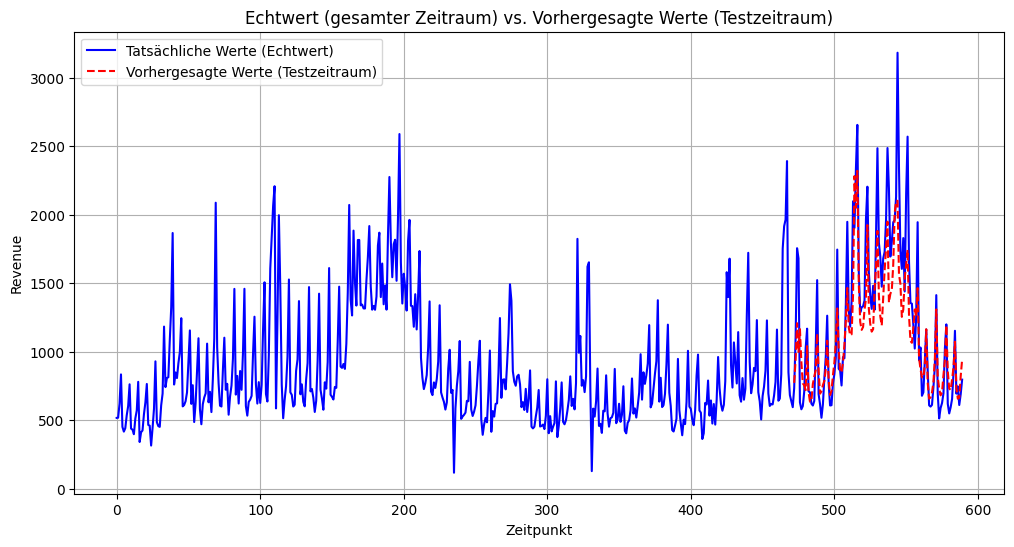

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Vorhersagen auf Testdaten
y_pred = model.predict(X_test)

# Tatsächliche Werte über den gesamten Zeitraum zurücktransformieren
all_y_inv = scaler.inverse_transform(
    np.concatenate((y_lagged.reshape(-1, 1), X_lagged[:, -1, :]), axis=1)
)[:, 0]

# Skalierten Output für Testdaten zurücktransformieren
y_test_inv = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), X_test[:, -1, :]), axis=1)
)[:, 0]
y_pred_inv = scaler.inverse_transform(
    np.concatenate((y_pred, X_test[:, -1, :]), axis=1)
)[:, 0]

# Fehler berechnen
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Visualisierung: Tatsächliche Werte über gesamten Zeitraum, vorhergesagte Werte nur für Testdaten
plt.figure(figsize=(12, 6))

# Tatsächliche Werte über gesamten Zeitraum
plt.plot(all_y_inv, label="Tatsächliche Werte (Echtwert)", color="blue")

# Vorhergesagte Werte nur für den Testzeitraum
test_range = range(len(all_y_inv) - len(y_test_inv), len(all_y_inv))
plt.plot(test_range, y_pred_inv, label="Vorhergesagte Werte (Testzeitraum)", color="red", linestyle="--")

plt.title("Echtwert (gesamter Zeitraum) vs. Vorhergesagte Werte (Testzeitraum)")
plt.xlabel("Zeitpunkt")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.show()


# Empfehlung

In [65]:
# Achtung Overfitting